In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Manual PreProcessing (Lower Case All)

In [1]:
#make all lowercase
def lower_df_text(df, text_columns):
    for column in text_columns:
        df[column] = df[column].apply(lambda x: x.lower())
    return

# Generating Wordclouds

In [2]:
from wordcloud import WordCloud
def plot_wordcloud(text, figname='wordcloud', colormap='Pastel2', stop_words=[]):
    '''
    Takes a string and plots the x most common words. 
    Set color by changing rgb parameter
    Font path may vary, if error use font_path=None
    
    '''
    font_path = "/Library/Fonts/DIN Condensed Bold.ttf"
    wc = WordCloud(background_color="white",max_words=25,
                   collocations=False, font_path=font_path, scale=5,stopwords=stop_words, colormap=colormap)#, color_func=lambda *args, **kwargs: rgb)
    wc.generate(text)
    
    fig, ax = plt.subplots(figsize=(14,18))
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('data/wordclouds/{}'.format(figname), dpi=240)


# Generating Network Graphs


In [3]:
import networkx as nx
from networkx.algorithms import community

In [4]:
# Functionize

def generate_graph(edge_filepath, node_filepath, title='gephi_graph'):
    edges = pd.read_csv(edge_filepath, header=None)
    nodes = pd.read_csv(node_filepath, header=None)
    edges.columns = ['Source', 'Target']
    nodes.columns = ['Node', 'Alias']
    nodes = nodes.astype('str')
    edges = edges.astype('str')
    edge_tuples = []
    for source, target in zip(edges['Source'], edges['Target']):
        edge_tuples.append((source, target))
    G = nx.DiGraph()
    G.add_nodes_from(nodes['Node'])
    G.add_edges_from(edge_tuples)
    print(nx.info(G))
    nx.write_gexf(G, edge_filepath.append('{}'.format(title)))
    

# Text Processing Pipeline (Too Slow)
from https://www.kaggle.com/balatmak/text-preprocessing-steps-and-universal-pipeline#Reusable-pipeline

In [5]:
import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise

nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1, custom_stop_words=[]):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs
        self.custom_stop_words=custom_stop_words

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if t.is_stop != True and t.text not in self.custom_stop_words  and 'https' not in t.text]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

ModuleNotFoundError: No module named 'spacy'

# Democratic Convention Data


#### 1.) Load df with processed text and descriptions

In [10]:
dconvention_df = pd.read_csv('large_data/dconvention_df.csv', index_col=0)
dconvention_df['user_description'].fillna('', inplace=True)
# nodes = 15,737
# edges = 88,537
# tweets = 134,687
# total users = 41,000

#### 2.) Load labeled community df

In [11]:
#top 5 democraty communities from gephi:
#18
#29
#70
#25
#46
#open labeled community nodes
dcommunity_df = pd.read_csv('large_data/communities_dconvention.csv', index_col='Id')
dcommunity_df.drop(columns=['timeset'], inplace=True)
dcommunity_df.drop(columns=['Label'], inplace=True)
dcommunity_df

,modularity_class
Id,
187059363,29
17546958,29
551557346,18
25073877,29
1339835893,18
...,...
224810490,196
576520016,70
616692598,70


#### 3.) Load node df to link community labels to the user names. Then merge community labels onto tweet df

In [12]:
dnodes_df = pd.read_csv('data/democrat/convention_mentions/dmention-nodes.csv')
dnodes_df = dnodes_df.join(dcommunity_df, how='left', on='Id')
dconvention_df = dconvention_df.merge(dnodes_df, left_on='user_screen_name', right_on='Label', how='outer')
dconvention_df['modularity_class'].dropna()

7          70.0
8          70.0
9          70.0
10         70.0
11         70.0
          ...  
149169    196.0
149170    196.0
149171     70.0
149172     70.0
149173     18.0
Name: modularity_class, Length: 26108, dtype: float64

In [13]:
#filter out all rows that don't have an assigned modularity class.
#we're left with 11,447 tweets (not bad)
dconvention_df = dconvention_df[dconvention_df['modularity_class'].isna() == False]

In [14]:
#drop the unneeded columns
features = [
        'id', 'place', 'user_location',
       'favorite_count', 
        'retweet_count', 
       'text', 
       'user_screen_name', 'user_description',
       'user_followers_count', 
       'user_name', 
       'Id', 'modularity_class']


dconvention_df = dconvention_df[features]
dconvention_df = dconvention_df[dconvention_df['text'].isna()==False]
dconvention_df.rename(columns={'modularity_class':'community'},inplace=True)

In [15]:
# group by user id and sum their tweets.

combined_text = dconvention_df.groupby(['user_screen_name']).apply(lambda x: ' '.join(x['text']))
combined_text.rename('combined_text',inplace=True)
dconvention_df = dconvention_df.merge(combined_text, left_on='user_screen_name',right_index=True)

user_summary = dconvention_df.groupby(['user_screen_name', 'user_location','user_description', 'combined_text', 'community']).mean()
user_summary.drop(columns=['id', 'Id'], inplace=True)
user_summary.reset_index(inplace=True)

#### 4.) Break top 5 communities into separate df and explore data

In [16]:
user_summary

,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
0,1031ent,"Dallas, TX",vip entertainer 1031ent tweeting magicianlifes...,vote jillstein tired corrupt corrupt bernieorb...,2363.0,4.000000,0.333333,31438.666667
1,10eBill,United States,,total fabrication herr trump question patriotism,1556.0,0.000000,0.000000,128.000000
2,1199SEIU,"New York, NY",mission win quality healthcare good jobs natio...,`` america greatness measured many millionaire...,18.0,4.562500,2.812500,17985.000000
3,15JudicialCASA,"CA.Bar, D.C. Bar retired to KC",keep love heart always life without sunless ga...,story teller extraordinaire man want fast alon...,25.0,0.416667,0.166667,1835.000000
4,201Bar,Capitol Hill - Washington DC,permanently closed,coming next week tonight 5 american whiskeys c...,1576.0,0.500000,0.000000,1153.000000
...,...,...,...,...,...,...,...,...
1115,zahavrestaurant,Philadelphia,ten years ’ calling zahav “ modern israeli res...,big thanks,219.0,3.000000,0.000000,11116.000000
1116,zdaniel,Melbourne Australia,reporter large|was bureau chief|se asia africa...,take look map rather interesting tv story last...,70.0,1.333333,1.666667,29680.000000
1117,zebraonice,"Phoenix, AZ",incredible parallel parker best contestant pri...,dems want circus tv think anymore corrupt keep...,18.0,0.000000,0.000000,459.000000
1118,ziibiing,"San Antonio, TX",ajijaak nindoodem internet planet communicator...,finally flight join hoping get good nap native...,106.0,4.882353,1.372549,9502.000000


In [17]:
community18 = user_summary[user_summary['community']==18.0]
community29 = user_summary[user_summary['community']==29.0]
community70 = user_summary[user_summary['community']==70.0]
community25 = user_summary[user_summary['community']==25.0]
community46 = user_summary[user_summary['community']==46.0]
community106 = user_summary[user_summary['community']==106.0]

#plot text word clouds
#plot_wordcloud((' '.join(community18['combined_text'])),figname='tweets_18', colormap='PuRd', stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
#plot_wordcloud((' '.join(community29['combined_text'])),figname='tweets_29', colormap='Greens', stop_words=['imwithher','demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
#plot_wordcloud((' '.join(community70['combined_text'])),figname='tweets_70', colormap='Blues',stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
#plot_wordcloud((' '.join(community25['combined_text'])),figname='tweets_25', colormap='Oranges',stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
#plot_wordcloud((' '.join(community46['combined_text'])),figname='tweets_46', colormap='PuRd', stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
#

In [ ]:
#plot user description word clouds

plot_wordcloud((' '.join(community18['user_description'])),figname='description_18', colormap='PuRd', stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community29['user_description'])),figname='description_29', colormap='Greens', stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community70['user_description'])),figname='description_70', colormap='Blues',stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community25['user_description'])),figname='description_25', colormap='Oranges',stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community46['user_description'])),figname='description_46', colormap='PuRd', stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])

In [18]:
#18
#29
#70
#25
#46

#users = community29.append(community70).append(community25).append(community46) # try leaving out the mainstream group
users = community18.append(community29).append(community70).append(community25).append(community46)


#### 5.) Vectorize / TFIDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

vectorizer = TfidfVectorizer()

X = users['user_description'] + users['combined_text']
y = users['community']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
#logistic model
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train);
lr_predict = lr.predict(X_test)
lr_score = lr.score(X_test, y_test)
print('Logistic Regression Model Score: {}'.format(lr_score))

#random forest
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train);
rf_predict = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)
print('Random Forest Model Score: {}'.format(rf_score))

#stochastic gradient descent
sgd = SGDClassifier(class_weight='balanced')
sgd.fit(X_train, y_train);
sgd_predict = sgd.predict(X_test)        
sgd_score = sgd.score(X_test, y_test)
print('SGD Model Score: {}'.format(sgd_score))

#naive_bayes
nb = MultinomialNB()
nb.fit(X_train, y_train);
nb_predict = nb.predict(X_test)
nb_score = nb.score(X_test, y_test)
print('NB Model Score: {}'.format(nb_score))

In [ ]:
cf = confusion_matrix(sgd_predict, y_test)
plot_confusion_matrix(sgd, X_test, y_test)

#### Try to get the top features for each community

In [28]:
feature_names = vectorizer.get_feature_names()
feature_names

['00',
 '000',
 '023',
 '09',
 '10',
 '100',
 '10am',
 '10x',
 '11',
 '114',
 '12',
 '12pm',
 '15',
 '150',
 '153m',
 '15am',
 '15pm',
 '16',
 '17',
 '18',
 '1878395',
 '19',
 '1a',
 '1billionrising',
 '1rva',
 '1st',
 '1stfemalemjrprtynominee',
 '1u',
 '20',
 '2014',
 '2016',
 '2019',
 '2020',
 '2020dems',
 '21',
 '22',
 '250',
 '25am',
 '27',
 '270on2016',
 '2a',
 '2t',
 '30',
 '300',
 '30am',
 '30ct',
 '30pm',
 '32',
 '333',
 '34',
 '35',
 '36th',
 '3am',
 '3rds',
 '40',
 '400',
 '4000',
 '40am',
 '442',
 '45',
 '45am',
 '4700',
 '48',
 '4moreyears',
 '50',
 '51state',
 '59',
 '600',
 '642',
 '651',
 '6abcaction',
 '72',
 '74',
 '7b',
 '800',
 '88',
 '8yearsinpower',
 '90sflashback',
 '914',
 '95',
 '98',
 '99',
 '9am',
 '9news',
 '9pm',
 'a1',
 'aaaand',
 'aaf',
 'aapi',
 'abandon',
 'abandoned',
 'abate',
 'abbey',
 'abbott',
 'abc',
 'abc13',
 'abc7',
 'abcsketches',
 'abdul',
 'abetted',
 'abiertas',
 'abigail',
 'abilities',
 'abilitiesanyone',
 'ability',
 'able',
 'abolir',
 

In [ ]:
labels = ['Mainstream/Liberals', 'Conservatives', 'News Media / Journalists', "Women / Women's Rights Advocates", 'Political Activists / Bernie Supporters']

/Users/jacobmullins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


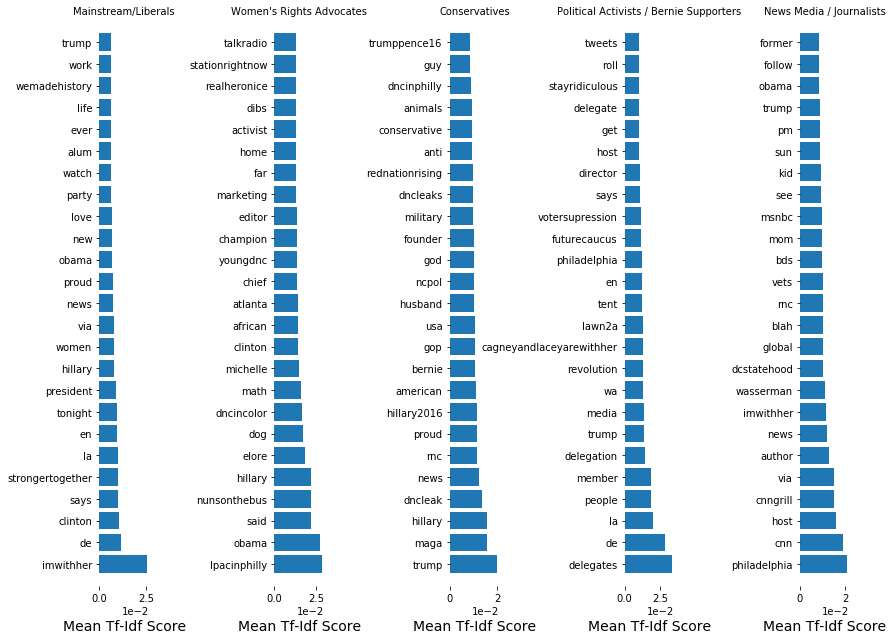

<Figure size 432x288 with 0 Axes>

In [26]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

top_feats_in_doc(X_train,feature_names,2)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs=top_feats_by_class(X_train,y_train,feature_names)

def plot_tfidf_classfeats_h(dfs, labels):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        #ax.set_title("label = " + str(df.label), fontsize=16)
        ax.set_title(labels[i], fontsize=10)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')#, color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.tight_layout()
        #plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    #plt.tight_layout()
    plt.savefig('data/wordclouds/TFIDF.png', dpi=240)
    
plot_tfidf_classfeats_h(dfs, labels = ['Mainstream/Liberals', "Women's Rights Advocates", 'Conservatives', 'Political Activists / Bernie Supporters', 'News Media / Journalists'])

In [27]:
dfs

[             feature     tfidf
 0          imwithher  0.025109
 1                 de  0.011549
 2            clinton  0.010391
 3               says  0.010126
 4   strongertogether  0.010112
 5                 la  0.009681
 6                 en  0.009273
 7            tonight  0.009254
 8          president  0.008621
 9            hillary  0.007893
 10             women  0.007824
 11               via  0.007785
 12              news  0.007477
 13             proud  0.007200
 14             obama  0.006821
 15               new  0.006658
 16              love  0.006484
 17             party  0.006439
 18             watch  0.006430
 19              alum  0.006383
 20              ever  0.006376
 21              life  0.006301
 22     wemadehistory  0.006189
 23              work  0.006102
 24             trump  0.006091,
             feature     tfidf
 0      lpacinphilly  0.028651
 1             obama  0.027693
 2              said  0.022171
 3      nunsonthebus  0.022155
 4          

#### Create a new feature "influence" which is a sum of user followers + total retweets + likes

In [ ]:
community18.sort_values(by='user_followers_count', ascending=False).head() # mainstream liberals 
community29.sort_values(by='user_followers_count', ascending=False).head().to_csv('data/democrat/community70.csv') # conservative
community70.sort_values(by='user_followers_count', ascending=False).head() # journalists
community25.sort_values(by='user_followers_count', ascending=False).head() # women / womens rights advocates
community46.sort_values(by='user_followers_count', ascending=False).head() # activists and political outsiders / bernie supporters
community106.sort_values(by='user_followers_count', ascending=False).head()

# Democratic Candidates Data

# Republican Candidates Data

In [23]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

top_feats_in_doc(X_train,feature_names,2)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs=top_feats_by_class(X_train,y_train,feature_names)

def plot_tfidf_classfeats_h(dfs, labels):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')#, color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.tight_layout()
        #plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    #plt.tight_layout()
    plt.savefig('data/wordclouds/TFIDF.png', dpi=240)
    
plot_tfidf_classfeats_h(dfs)

TypeError: plot_tfidf_classfeats_h() missing 1 required positional argument: 'labels'

In [22]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
def top_tfidf_feats(row, features, top_n=25):
    ‘’' Get top n tfidf values in row and return them with their corresponding feature names.‘’'
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = [‘feature’, ‘tfidf’]
    return df
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)
top_feats_in_doc(X_train,feature_names,2)
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ‘’' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. ‘’'
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ‘’' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. ‘’'
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs=top_feats_by_class(X_train,y_train,feature_names)
def plot_tfidf_classfeats_h(dfs, labels):
    ‘’' Plot the data frames returned by the function plot_tfidf_classfeats(). ‘’'
    fig = plt.figure(figsize=(12, 9), facecolor=“w”)
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines[“top”].set_visible(False)
        ax.spines[“right”].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel(“Mean Tf-Idf Score”, labelpad=16, fontsize=14)
        ax.set_title(“label = ” + str(df.label), fontsize=16)
        ax.ticklabel_format(axis=‘x’, style=‘sci’, scilimits=(-2,2))
        ax.barh(x, df.tfidf, align=‘center’)#, color=‘#3F5D7D’)
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.tight_layout()
        #plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    #plt.tight_layout()
    plt.savefig(‘data/wordclouds/TFIDF.png, dpi=240)
plot_tfidf_classfeats_h(dfs)















SyntaxError: invalid character in identifier (<ipython-input-22-6a77474269b4>, line 7)